# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [1]:
import pandas as pd
import re

## Mutational catalogs and activities - WGS data

In [2]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  Biliary-AdenoCA::SP117655  \
0           C>A           ACA                        269   
1           C>A           ACC                        148   

   Biliary-AdenoCA::SP117556  Biliary-AdenoCA::SP117627  \
0                        114                        105   
1                         56                         71   

   Biliary-AdenoCA::SP117775  Biliary-AdenoCA::SP117332  \
0                        217                         52   
1                        123                         36   

   Biliary-AdenoCA::SP117712  Biliary-AdenoCA::SP117017  \
0                        192                         54   
1                        139                         54   

   Biliary-AdenoCA::SP117031  ...  Uterus-AdenoCA::SP94540  \
0                        196  ...                      117   
1                        102  ...                       90   

   Uterus-AdenoCA::SP95222  Uterus-AdenoCA::SP89389  Uterus-AdenoCA::SP90503  \
0                      233                       94                      114   
1                      167                       59                       64   

   Uterus-AdenoCA::SP92460  Uterus-AdenoCA::SP92931  Uterus-AdenoCA::SP91265  \
0                      257                      139                      404   
1                      268                       75                      255   

   Uterus-AdenoCA::SP89909  Uterus-AdenoCA::SP90629  Uterus-AdenoCA::SP95550  
0                       97                      250                      170  
1                       78                      188                      137  

[2 rows x 2782 columns]

Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [3]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0  Biliary-AdenoCA     SP117655     0.968  1496  1296     0     0  1825     0   
1  Biliary-AdenoCA     SP117556     0.963   985     0     0     0   922     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

In [4]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

Mutation type Trinucleotide  ALL::PD4020a  ALL::SJBALL011_D  \
0           C>A           ACA            35                 9   
1           C>A           ACC            16                 2   

   ALL::SJBALL012_D  ALL::SJBALL020013_D1  ALL::SJBALL020422_D1  \
0                 2                     7                     5   
1                 4                    10                     5   

   ALL::SJBALL020579_D1  ALL::SJBALL020589_D1  ALL::SJBALL020625_D1  ...  \
0                     7                     3                     5  ...   
1                     9                     1                     2  ...   

   Stomach-AdenoCa::pfg316T  Stomach-AdenoCa::pfg317T  \
0                       133                       185   
1                        48                        70   

   Stomach-AdenoCa::pfg344T  Stomach-AdenoCa::pfg373T  \
0                       202                       185   
1                       126                        88   

   Stomach-AdenoCa::pfg375T  Stomach-AdenoCa::pfg378T  \
0                        96                       134   
1                        35                        54   

   Stomach-AdenoCa::pfg398T  Stomach-AdenoCa::pfg413T  \
0                        12                       279   
1                        16                       112   

   Stomach-AdenoCa::pfg416T  Stomach-AdenoCa::pfg424T  
0                        75                       135  
1                        31                        91  

[2 rows x 1867 columns]

In [5]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  SBS5  SBS6  \
0          ALL      PD4020a     0.995   208  3006     0     0   365     0   
1          ALL  SJBALL011_D     0.905    66     0     0     0   144     0   

   SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  SBS58  SBS59  \
0      0  ...      0      0      0      0      0      0      0      0      0   
1      0  ...      0      0      0      0      0      0      0      0      0   

   SBS60  
0      0  
1      0  

[2 rows x 68 columns]

## Mutational catalogs - WES data

In [6]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

Mutation type Trinucleotide  AML::TCGA-AB-2802-03B-01W-0728-08  \
0           C>A           ACA                                  0   
1           C>A           ACC                                  0   

   AML::TCGA-AB-2803-03B-01W-0728-08  AML::TCGA-AB-2804-03B-01W-0728-08  \
0                                  0                                  0   
1                                  2                                  0   

   AML::TCGA-AB-2805-03B-01W-0728-08  AML::TCGA-AB-2806-03B-01W-0728-08  \
0                                  0                                  4   
1                                  0                                  0   

   AML::TCGA-AB-2807-03B-01W-0728-08  AML::TCGA-AB-2808-03B-01W-0728-08  \
0                                  0                                  2   
1                                  1                                  3   

   AML::TCGA-AB-2809-03D-01W-0755-09  ...  \
0                                  0  ...   
1                                  0  ...   

   Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08  \
0                                           1   
1                                           0   

   Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08  \
0                                           0   
1                                           1   

   Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08  \
0                                           0   
1                                           0   

   Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08  
0                                           0  
1                                           0  

[2 rows x 9495 columns]

In [7]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

Cancer Types                  Sample Names  Accuracy  SBS1  SBS2  SBS3  \
0          AML  TCGA-AB-2802-03B-01W-0728-08     0.811     3     0     0   
1          AML  TCGA-AB-2803-03B-01W-0728-08     0.608     4     0     0   

   SBS4  SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  \
0     0     0     0      0  ...      0      0      0      0      0      0   
1     0     7     0      0  ...      0      0      0      0      0      0   

   SBS57  SBS58  SBS59  SBS60  
0      0      0      0      0  
1      0      0      0      0  

[2 rows x 68 columns]

In [8]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

Mutation type Trinucleotide  ALL::TARGET-10-PAIXPH-03A-01D  \
0           C>A           ACA                              0   
1           C>A           ACC                              0   

   ALL::TARGET-10-PAKHZT-03A-01R  ALL::TARGET-10-PAKMVD-09A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAKSWW-03A-01D  ALL::TARGET-10-PALETF-03A-01D  \
0                              1                              0   
1                              1                              0   

   ALL::TARGET-10-PALLSD-09A-01D  ALL::TARGET-10-PAMDKS-03A-01D  \
0                              0                              0   
1                              0                              0   

   ALL::TARGET-10-PAPJIB-04A-01D  ...  Head-SCC::V-109  Head-SCC::V-112  \
0                              2  ...                0                0   
1                              0  ...                1                0   

   Head-SCC::V-116  Head-SCC::V-119  Head-SCC::V-123  Head-SCC::V-124  \
0                0                0                0                0   
1                0                0                0                0   

   Head-SCC::V-125  Head-SCC::V-14  Head-SCC::V-29  Head-SCC::V-98  
0                0               0               0               1  
1                0               1               0               0  

[2 rows x 9693 columns]

In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

Cancer Types              Sample Names  Accuracy  SBS1  SBS2  SBS3  SBS4  \
0          ALL  TARGET-10-PAIXPH-03A-01D     0.529     0     0     0     0   
1          ALL  TARGET-10-PAKHZT-03A-01R     0.696     0     0     0     0   

   SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  SBS55  SBS56  SBS57  \
0     0     0      0  ...      0      0      0      1      0      0      0   
1     0     0      0  ...      0      0      0      1      0      0      0   

   SBS58  SBS59  SBS60  
0      0      0      0  
1      0      0      0  

[2 rows x 68 columns]

In [33]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

{'Myeloid-MPN', 'CNS-Oligo', 'Bone-Epith', 'Eso-AdenoCA', 'Stomach-AdenoCA', 'Bladder-TCC', 'Cervix-SCC', 'Breast-LobularCA', 'SoftTissue-Liposarc', 'CNS-PiloAstro', 'Head-SCC', 'Lung-AdenoCA', 'Liver-HCC', 'Kidney-RCC', 'Uterus-AdenoCA', 'Lymph-BNHL', 'Myeloid-AML', 'Prost-AdenoCA', 'CNS-Medullo', 'SoftTissue-Leiomyo', 'Kidney-ChRCC', 'Breast-DCIS', 'Bone-Benign', 'Myeloid-MDS', 'Lymph-CLL', 'Panc-Endocrine', 'Lung-SCC', 'Ovary-AdenoCA', 'Skin-Melanoma', 'Panc-AdenoCA', 'Breast-AdenoCA', 'Biliary-AdenoCA', 'Bone-Osteosarc', 'Thy-AdenoCA', 'ColoRect-AdenoCA', 'CNS-GBM', 'Cervix-AdenoCA'}


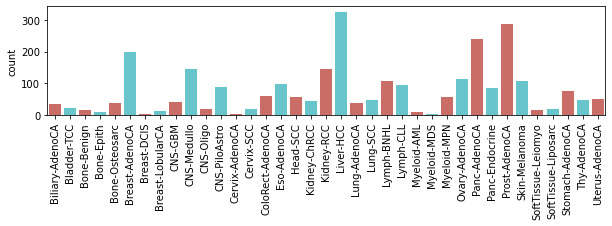

In [23]:
n_mut_types, n_samples = PCAWG_wgs_mut.shape
#print(PCAWG_wgs_mut.head())

mutations_wgs  = PCAWG_wgs_mut.copy()
mutations_wgs['mut_tri'] = mutations_wgs.apply(lambda a: '{}_{}'.format(a['Mutation type'], a['Trinucleotide']), axis=1)
mutations_wgs = mutations_wgs.set_index('mut_tri').drop(['Mutation type', 'Trinucleotide'], axis=1)
mutations_wgs = mutations_wgs.T
mutations_wgs[:5]

tumor_types_wgs = [a.split(':')[0] for a in mutations_wgs.index]
print(set(tumor_types_wgs))

plt.figure(figsize=(10, 2))
sns.countplot(x=tumor_types_wgs, palette=sns.hls_palette(2))
plt.xticks(rotation=90);



In [27]:
target_type = tumor_types_wgs[0]
print("target", target_type)

wgs_labels = [1 if tumor_type == target_type else 0 for tumor_type in tumor_types_wgs]
X_train, X_test, y_train, y_test = train_test_split(mutations_wgs, wgs_labels, test_size = 0.3, random_state=1)

print(X_train.shape, X_test.shape)



target Biliary-AdenoCA
(1946, 96) (834, 96)


In [35]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
y_model = model.predict(X_test)
accuracy_score(y_test, y_model)

0.9904076738609112